# Monotonic Output Regression

This notebook accompanies the paper [Learning Convex Optimization Models](https://web.stanford.edu/~boyd/papers/learning_copt_models.html).

In [4]:
import torch
import numpy as np
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import cvxpylayers
from algorithms import fit
import matplotlib.pyplot as plt
from latexify import latexify
cp.__version__, cvxpylayers.__version__

('1.1.0a4', '0.1.3')

In [5]:
# Define convex optimization model
n = 20
m = 10

y = cp.Variable(m)
yhat = cp.Parameter(m)

objective = cp.norm2(y-yhat)
constraints = [cp.diff(y) >= 0]
prob = cp.Problem(cp.Minimize(objective), constraints)
layer = CvxpyLayer(prob, [yhat], [y])

In [6]:
# Get data
def get_data(N, n, m, theta):
    X = torch.randn(N, n)
    Y = layer(X @ theta + torch.randn(N, m))[0]
    return X, Y

torch.manual_seed(0)
theta_true = torch.randn(n, m)
X, Y = get_data(100, n, m, theta_true)
Xval, Yval = get_data(50, n, m, theta_true)

In [7]:
mse_loss = torch.nn.MSELoss()
theta_lstsq = torch.solve(X.t() @ Y, X.t() @ X).solution
lstsq_val_loss = mse_loss(Xval @ theta_lstsq, Yval).item()
bayes_val_loss = mse_loss(layer(Xval @ theta_true)[0], Yval).item()

In [8]:
theta = torch.zeros_like(theta_lstsq)
theta.requires_grad_(True)
def loss(X, Y, theta):
    return mse_loss(layer(X @ theta)[0], Y)

In [10]:
val_losses, train_losses = fit(lambda X, Y: loss(X, Y, theta), [theta], X, Y, Xval, Yval,
                               opt=torch.optim.Adam, opt_kwargs={"lr": 1e-1},
                               batch_size=16, epochs=20, verbose=True)

001 | 6.37966
batch 001 / 007 | 6.54562
batch 002 / 007 | 7.21317
batch 003 / 007 | 6.77889
batch 004 / 007 | 6.75470
batch 005 / 007 | 5.97233
batch 006 / 007 | 5.50823
batch 007 / 007 | 5.41007
002 | 3.67326
batch 001 / 007 | 2.82474
batch 002 / 007 | 3.14247
batch 003 / 007 | 2.68744
batch 004 / 007 | 2.79289
batch 005 / 007 | 2.84320
batch 006 / 007 | 2.73215
batch 007 / 007 | 2.60307
003 | 2.77888
batch 001 / 007 | 1.78423
batch 002 / 007 | 1.69969
batch 003 / 007 | 1.88519
batch 004 / 007 | 1.79895
batch 005 / 007 | 1.76285
batch 006 / 007 | 1.71602
batch 007 / 007 | 1.83642
004 | 2.20847
batch 001 / 007 | 1.27333
batch 002 / 007 | 1.44328
batch 003 / 007 | 1.33678
batch 004 / 007 | 1.29789
batch 005 / 007 | 1.30782
batch 006 / 007 | 1.31228
batch 007 / 007 | 1.23183
005 | 1.79820
batch 001 / 007 | 0.71949
batch 002 / 007 | 0.82146
batch 003 / 007 | 0.96098
batch 004 / 007 | 0.94970
batch 005 / 007 | 0.92515
batch 006 / 007 | 0.97964
batch 007 / 007 | 1.09865
006 | 1.43201
batch 

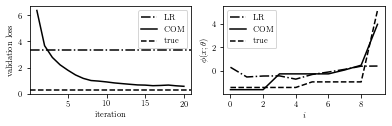

In [30]:
latexify(5.485, 1.8)
fig, ax = plt.subplots(1, 2)

ax[0].axhline(lstsq_val_loss, linestyle='-.', c='black', label='LR')
ax[0].plot(np.arange(1, 21), val_losses, c='k', label='COM')
ax[0].axhline(bayes_val_loss, linestyle='--', c='black', label='true')
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("validation loss")
ax[0].set_ylim(0)
ax[0].legend()

ax[1].plot(Xval[13] @ theta_lstsq, '-.', c='k', label='LR')
ax[1].plot(layer(Xval[13] @ theta)[0].detach().numpy(), c='k', label='COM')
ax[1].plot(Yval[13].numpy(), '--', c='k', label='true')
ax[1].legend()
ax[1].set_xlabel('$i$')
ax[1].set_ylabel("$\phi(x;\\theta)$")

plt.tight_layout()
plt.savefig("figures/mono_regression.pdf")
plt.show()

In [33]:
lstsq_val_loss

3.3753725951890483

In [23]:
print(loss(X, Y, theta_lstsq).item())

1.5115945280018195


In [31]:
val_losses[-1]

0.5620522413492108

In [32]:
bayes_val_loss

0.2637994455876921